In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import trange
import numpy as np
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(69)
dev

'cuda'

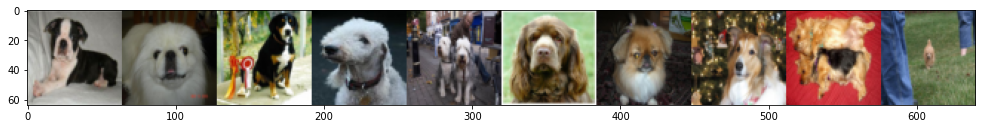

In [2]:
trans = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                            transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
dataset = ImageFolder('./dataset/', transform=trans)
BS = 256
dtld = DataLoader(dataset, batch_size=BS, shuffle=True, drop_last=True)
a = next(iter(dtld))
def implot(imgs, losses=False, save=False):
    imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy()
    img = np.concatenate(imgs, axis=1)
    
    fig, axs = plt.subplots(1 + losses)
    fig.set_size_inches((17, 6))
    if losses:
        axs[0].plot(g_losses, label='Generator losses')
        axs[0].plot(d_losses, label='Discriminator losses')
        axs[1].imshow(img)
    else:
        axs.imshow(img)
    plt.show()
    if save:
        fig.savefig(f'./images/epoch_{epoch}')
implot(a[0][:10])

In [3]:
def load():
    checkpoint = torch.load('checkpoint.pth')
    last_epoch = checkpoint['epoch']
    g.load_state_dict(checkpoint['g_state_dict'])
    d.load_state_dict(checkpoint['d_state_dict'])
    g_optim.load_state_dict(checkpoint['g_optim_state_dict'])
    d_optim.load_state_dict(checkpoint['d_optim_state_dict'])
    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']
    
    return last_epoch, g_losses, d_losses

def save():
    torch.save({
                'epoch': epoch,
                 'g_state_dict': g.state_dict(),
                'd_state_dict': d.state_dict(),
                'g_optim_state_dict': g_optim.state_dict(),
                'd_optim_state_dict': d_optim.state_dict(),
                'g_losses': g_losses,
                'd_losses': d_losses,
                }, 'checkpoint.pth')

In [4]:
class PrintShape(nn.Module):
    def __init__(self):
        super(PrintShape, self).__init__()
    def forward(self, x):
        print(x.shape)
        return x
    
class GaussianNosie(nn.Module):
    def __init__(self):
        super(GaussianNosie, self).__init__()
        self.std = nn.parameter.Parameter(torch.tensor(.1))
    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(0, self.std.data.item())

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.noise = GaussianNosie()

        def block(in_c, out_c, bn=True):
            b = [
#                 nn.utils.spectral_norm(
                    nn.Conv2d(in_c, out_c, 5, 2, 2, bias=False),
            ]
            if bn:
                b.append(nn.BatchNorm2d(out_c))
            b.append(nn.LeakyReLU(.2, inplace=True))
            return b

        self.conv = nn.Sequential(
            *block(3, 64, bn=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 4, bias=False),
            nn.Sigmoid()
        )
        self.flat = nn.Flatten()
    def forward(self, x):
#         x = self.noise(x)
        x = self.conv(x)
        return self.flat(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_c, out_c):
            return [
#                 nn.utils.spectral_norm(
                    nn.ConvTranspose2d(in_c, out_c, 5, 2, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
        self.conv = nn.Sequential(
            *block(100, 512),
            *block(512, 256),
            *block(256, 128),
            *block(128, 64),
            nn.ConvTranspose2d(64, 3, 5, 2, 1, 1, bias=False),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.conv(x.view(-1, 100, 1, 1))

g = Generator().to(dev)
d = Discriminator().to(dev)
g_losses = []
d_losses = []
d(g(torch.randn((BS, 100), device=dev))).shape
# g(torch.randn((BS, 100), device=dev)).shape

torch.Size([256, 1])

In [5]:
def train_test_loop(dtld, train=True):
    for i, (x, _) in enumerate(dtld):
        x = x.to(dev)

        z = torch.randn((BS, 100), device=dev)
        ones, zeros = torch.full([BS], .9, device=dev), torch.zeros((BS), device=dev)
        gen_imgs = g(z)
        
        # Train generator
        for p in g.parameters():
            p.grad = None
        y_hat = d(gen_imgs).reshape((-1))
        g_loss = g_crit(y_hat, ones)
        g_loss.backward()
        g_optim.step()

        # Train discriminator
        for p in d.parameters():
            p.grad = None
        ones_hat, zeros_hat = d(x).reshape((-1)), d(gen_imgs.detach()).reshape((-1))
        d_loss = (d_crit(ones_hat, ones) + d_crit(zeros_hat, zeros)) / 2
        d_loss.backward()
        d_optim.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

  0%|          | 0/199 [00:00<?, ?it/s]

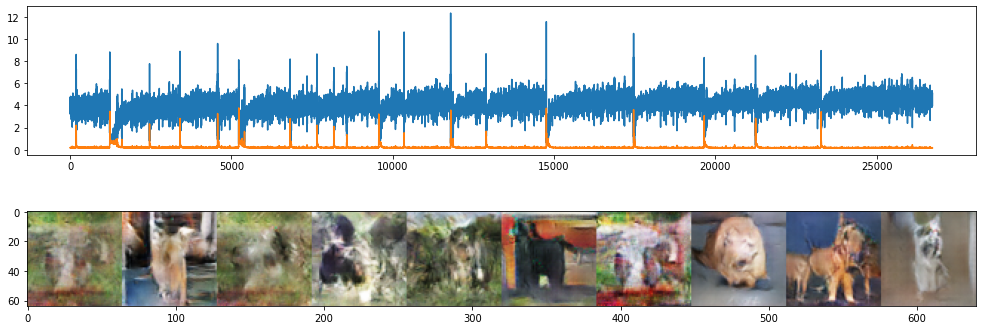

  0%|          | 0/199 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [6]:
g_crit = nn.BCELoss()
d_crit = nn.BCELoss()
g_optim = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(.5, .999))
d_optim = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(.5, .999))
last_epoch, g_losses, d_losses = load()
epochs = last_epoch + 200

for epoch in (t := trange(last_epoch + 1, epochs)):
    implot(g(torch.randn((BS, 100), device=dev))[:10], losses=True, save=True)
    save()
    train_test_loop(dtld)
    t.set_description(f'D_losses=%.4f | G_losses=%.4f' % (d_losses[-1], g_losses[-1]))

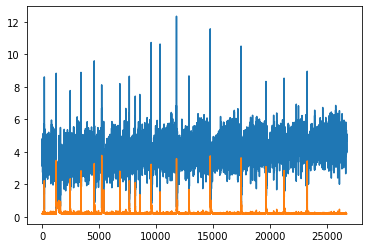

In [7]:
plt.plot(g_losses, label='Generator losses')
plt.plot(d_losses, label='Discriminator losses')
plt.show()

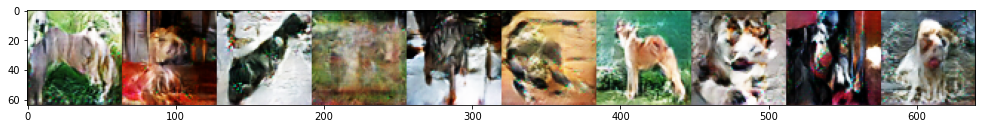

In [11]:
implot(g(torch.randn((BS, 100), device=dev)[:10]))